In [3]:
from ultralytics import YOLO
import cv2
import math
import matplotlib.pyplot as plt
import pytesseract
import easyocr
import numpy as np

In [ ]:
# Cargar modelo
model = YOLO('yolov8n.yaml') # Construir nuevo modelo desde yaml

results = model.train(data='license_plates_dataset/data.yaml', epochs=20, imgsz=640, patience=20)



0: 256x640 2 License-Platess, 59.7ms
Speed: 1.0ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)


Confidence ---> 0.45
Class name --> matricula
Confidence ---> 0.44
Class name --> matricula


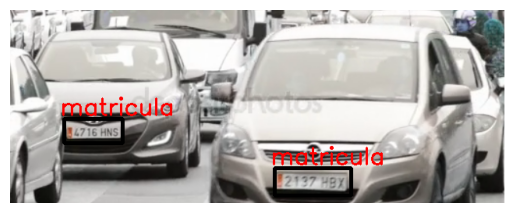

In [57]:
bestModel = YOLO('runs/detect/train4/weights/best.pt')
classNames = ['matricula'] 

image_path = 'media/imagetest5.png'
img = cv2.imread(image_path)


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = bestModel(img, stream=True)

for r in results:
    boxes = r.boxes

    for box in boxes:
        # Contenedor
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
        
        # Confianza
        confidence = math.ceil((box.conf[0]*100))/100
        print("Confidence --->",confidence)           

        # Clase
        cls = int(box.cls[0])
        print("Class name -->", classNames[cls])

        # Convierte identificador numérico de clase a un color RGB
        escala = int((cls / len(classNames)) * 255 * 3)
        if escala >= 255*2:
            R = 255
            G = 255
            B = escala - 255*2
        else:
            if escala >= 255:
                R = 255
                G = escala - 255
                B = 0
            else:
                R = escala
                G = 0
                B = 0

        # Dibuja el contenedor y clase
        cv2.rectangle(img, (x1, y1), (x2, y2), (R, G, B), 3)
        cv2.putText(img, classNames[cls] , [x1 -5, y1 -5], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, B), 2)

        license_plate_crop = img[y1 - 10:y2 + 10, x1 - 10:x2 + 10]
        license_plate_crop_resized = cv2.resize(license_plate_crop, (250, 150))
        license_plate_crop_gray = cv2.cvtColor(license_plate_crop_resized, cv2.COLOR_BGR2GRAY)

        license_plate_crop_thresh = cv2.adaptiveThreshold(license_plate_crop_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)


plt.axis("off")
plt.imshow(img) 
plt.show()







['eng', 'osd']


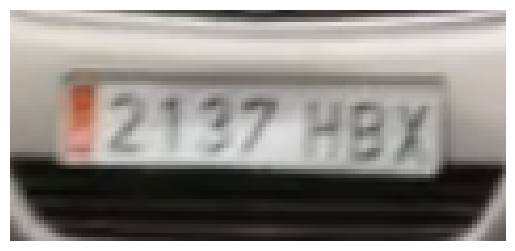

NNT

1

Thi37 ta
% ny



In [44]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Lenguajes disponibles
print(pytesseract.get_languages(config=''))

#Cargo imagen y ocnvierto a RGB

#gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17)
#canny_edge = cv2.Canny(gray_image, 30, 200)



plt.axis("off")
plt.imshow(license_plate_crop) 
plt.show()


#Aplica reconocedor a imagen cargada
print(pytesseract.image_to_string(license_plate_crop_thresh))

In [54]:
#Carga del modelo de lengua
reader = easyocr.Reader(['en'], gpu=False) 

#Reconocimiento de una imagen
total_license = ""
results = reader.readtext(license_plate_crop)
for result in results:
    bbox, text, score = result
    text = text.upper().replace(' ', '')
    total_license += text
print(total_license)


Using CPU. Note: This module is much faster with a GPU.


42137HBYI
